In [2]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
import pandas as pd
import os
import PIL
import warnings
import glob
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator , DirectoryIterator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
!pip install Augmentor
import Augmentor
%matplotlib inline

In [6]:
# Read the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Test')

In [8]:
# Print the number of images in  taining &  test data set
image_count_train = len(list(data_dir_train.glob('*/*.jpg*')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


In [4]:
# Define parameters
batch_size = 32
img_size = (180,180)
num_classes = 9
epochs = 20

In [5]:
# Use GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available : " , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

GPUs available :  1


In [9]:
# Train / Validation data  split of 80: 20 % , rescaling done
train_datagen = ImageDataGenerator(rescale=1./255 , validation_split=0.2)

In [10]:
train_batches = train_datagen.flow_from_directory(data_dir_train, target_size = img_size ,
                                                  batch_size = batch_size , color_mode = 'rgb' , seed = 123,
                                                  class_mode = 'categorical',subset = 'training' )

Found 1795 images belonging to 9 classes.


In [11]:
test_batches = train_datagen.flow_from_directory(data_dir_train, target_size = img_size ,
                                                  batch_size = batch_size , color_mode = 'rgb' , seed = 123,
                                                  class_mode = 'categorical',subset = 'validation' )

Found 444 images belonging to 9 classes.


In [12]:
# Print shape of Train batch
img_shape = train_batches.image_shape
print(img_shape)

(180, 180, 3)


In [13]:
# Prepare the test file 180 by 180 pixcel
test_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Test', color_mode = "rgb" ,image_size= img_size,seed= 123)

Found 118 files belonging to 9 classes.


In [14]:
# List out all the classes of skin cancer and store them in a list.
class_names = test_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [16]:
# Visualize the data
def plotImages(images_arr):
  fig , axes = plt.subplots(1,9,figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr,axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

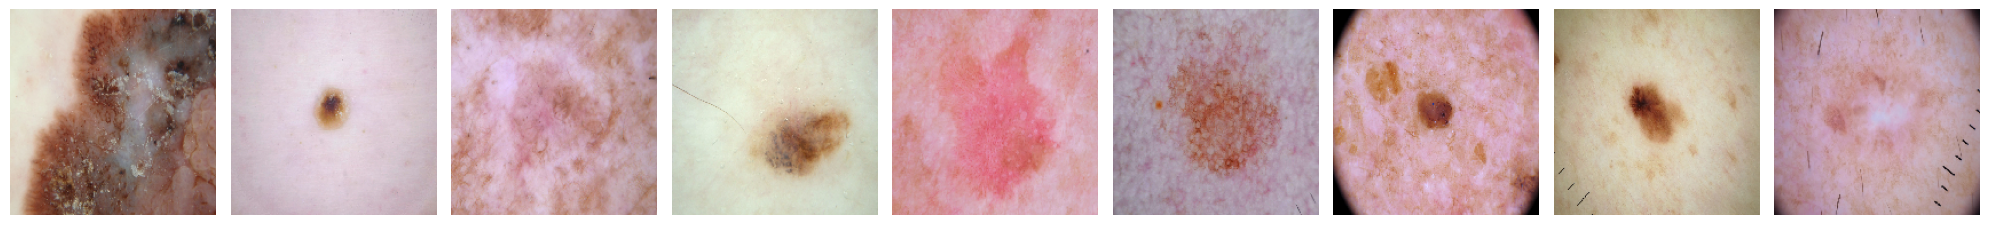

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [17]:
imgs,labels = train_batches[0]
plotImages(imgs)
print(labels[:8])

In [23]:
# Build the CNN model using 4 Convolution layers
# Each layer is followed by Max Pooling layer
# Regularization is used by Dropout layer
model = Sequential([
    Conv2D(128, (3,3),1,activation='relu', padding='same',input_shape = img_shape) ,
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(64, (3,3),1,activation='relu', padding='same',input_shape = img_shape) ,
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(32, (3,3),1,activation='relu', padding='same',input_shape = img_shape),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(16, (3,3),1,activation='relu', padding='same',input_shape = img_shape),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.4),
    Dense(num_classes , activation = 'softmax')
   ])



In [24]:
# Printing the Summary of the model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 23, 23, 32)       

In [25]:
# Model Compilation using  : Loss Function  - categorical_crossentropy
# and Optimizer 'sdg'
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [26]:
# Training the model with 20 epochs & 32 batch size
history = model.fit(train_batches, batch_size=batch_size, epochs= epochs, validation_data=test_batches ,shuffle=True)

Epoch 1/20
57/57 [==============================] - 31s 519ms/step - loss: 2.0885 - accuracy: 0.1877 - val_loss: 2.0204 - val_accuracy: 0.2072
Epoch 2/20
57/57 [==============================] - 26s 461ms/step - loss: 2.0284 - accuracy: 0.2150 - val_loss: 2.0164 - val_accuracy: 0.1959
Epoch 3/20
57/57 [==============================] - 29s 514ms/step - loss: 2.0261 - accuracy: 0.2072 - val_loss: 2.0075 - val_accuracy: 0.2005
Epoch 4/20
57/57 [==============================] - 25s 441ms/step - loss: 2.0189 - accuracy: 0.2123 - val_loss: 2.0120 - val_accuracy: 0.1959
Epoch 5/20
57/57 [==============================] - 26s 453ms/step - loss: 2.0137 - accuracy: 0.2189 - val_loss: 2.0022 - val_accuracy: 0.2230
Epoch 6/20
57/57 [==============================] - 25s 443ms/step - loss: 2.0057 - accuracy: 0.2379 - val_loss: 2.0031 - val_accuracy: 0.1824
Epoch 7/20
57/57 [==============================] - 24s 421ms/step - loss: 1.9945 - accuracy: 0.2485 - val_loss: 1.9802 - val_accuracy: 0.2185

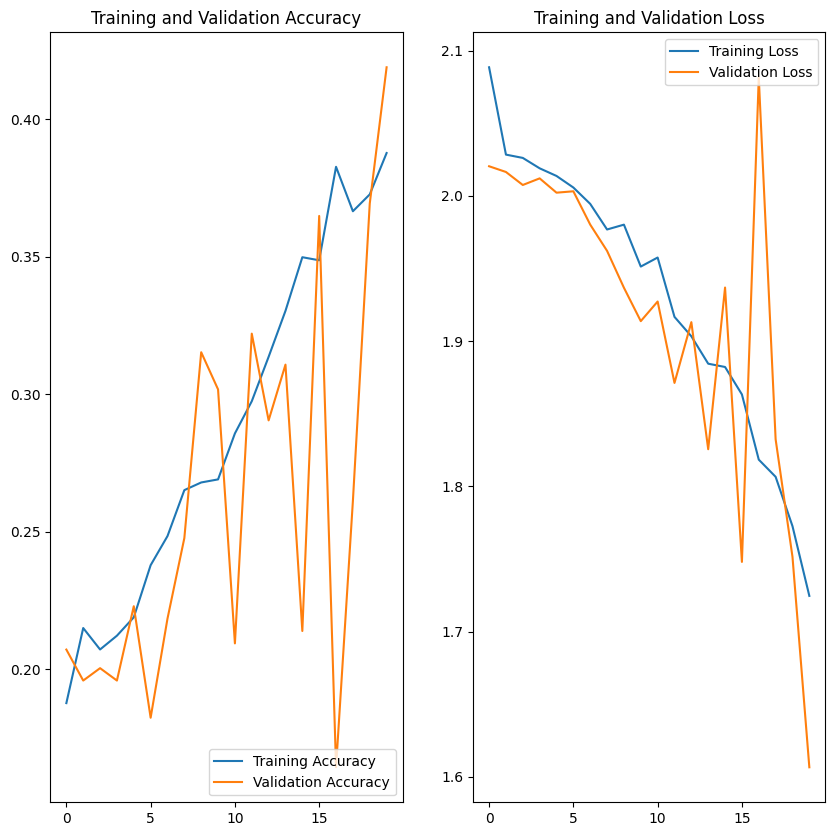

In [27]:
# Visualizing  the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#The model implies underfitting .
# Training accuracy = 38.77% and Validation Accuracy = 41.89%
# There is data imbalance in the classes of training data set .
# We will augment the training data & add 500 samples per class & re run the model .

In [28]:
# Handling class imbalance
path_to_training_dataset ='/content/drive/MyDrive/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)       ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7869605C3550>: 100%|██████████| 500/500 [00:16<00:00, 29.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786975747370>: 100%|██████████| 500/500 [00:16<00:00, 29.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7869604A6E60>: 100%|██████████| 500/500 [00:18<00:00, 27.20 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78696035C3A0>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7869607071F0>: 100%|██████████| 500/500 [01:27<00:00,  5.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7869FE8FEA10>: 100%|██████████| 500/500 [00:16<00:00, 29.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78696032A3B0>: 100%|██████████| 500/500 [00:39<00:00, 12.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786960707A30>: 100%|██████████| 500/500 [00:16<00:00, 30.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78696036CFA0>: 100%|██████████| 500/500 [00:16<00:00, 29.83 Samples/s]


In [ ]:
#  Question 1 : Which class has the least number of samples?
#  Answer 1   : Subclass pigmented benign keratosis has minimum number of Samples  - 77
#  Question 2 : Which classes dominate the data in terms proportionate number of samples?
#  Answer 2   : Subclass dermatofibroma (438) and nevus (462) dominate the data in terms of Sample numbers

In [29]:
# Print image count in output folder after augmenting
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [31]:
# Building Train set  with new augmented data samples
train_batches_aug = train_datagen.flow_from_directory(data_dir_train, target_size = img_size ,
                                                  batch_size = batch_size , color_mode = 'rgb' , seed = 123,
                                                  class_mode = 'categorical',subset = 'training' )


Found 5395 images belonging to 9 classes.


In [34]:
# Building Test set  with new augmented data samples
test_batches_aug = train_datagen.flow_from_directory(data_dir_train, target_size = img_size ,
                                                  batch_size = batch_size , color_mode = 'rgb' , seed = 123,
                                                  class_mode = 'categorical',subset = 'validation' )

Found 1344 images belonging to 9 classes.


In [32]:
img_shape = train_batches_aug.image_shape
print(img_shape)

(180, 180, 3)


In [ ]:
# Training the model with augmented data samples and run for 30 epochs
epochs = 30
history_aug = model.fit(train_batches_aug , batch_size=batch_size, epochs= epochs, validation_data=test_batches_aug ,shuffle=True)

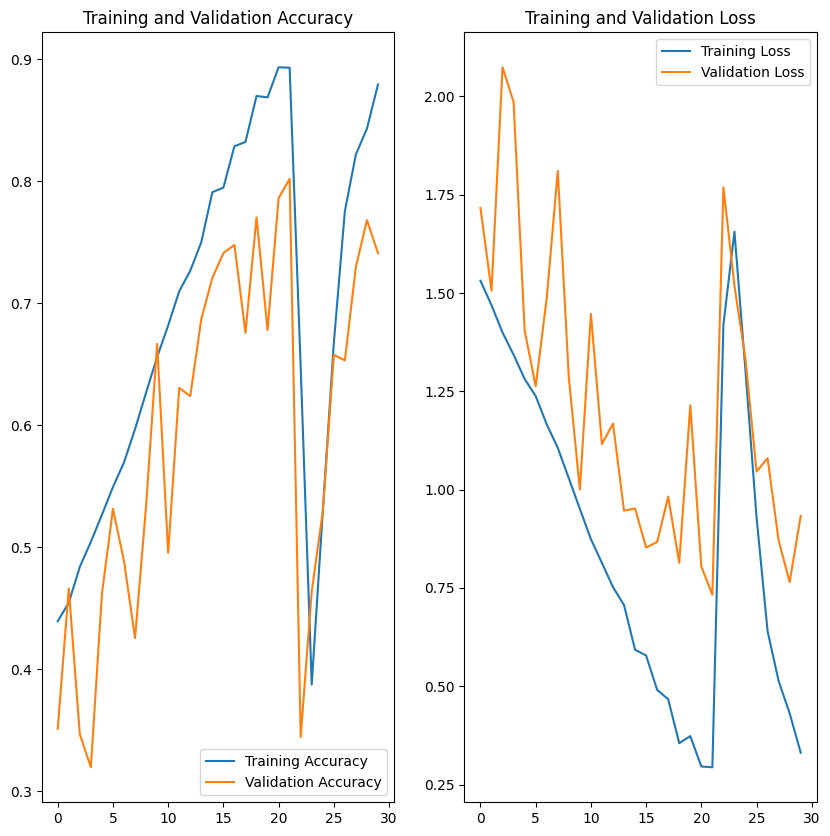

In [40]:
# Visualize the training results
epochs_range = range(epochs)

acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Looking at the above plot , its clear that after 22 epochs the losses increase & accuracy decrease .
# Hence for the final model we will use NO of Epochs as 22 instead of 30  .

In [49]:
# Training the model with augmented data samples and run for 30 epochs
epochs = 22
history_final = model.fit(train_batches_aug , batch_size=batch_size, epochs= epochs, validation_data=test_batches_aug ,shuffle=True)

Epoch 1/22
169/169 [==============================] - 60s 353ms/step - loss: 0.2867 - accuracy: 0.8966 - val_loss: 0.7428 - val_accuracy: 0.7924
Epoch 2/22
169/169 [==============================] - 52s 309ms/step - loss: 0.3017 - accuracy: 0.8992 - val_loss: 0.7569 - val_accuracy: 0.7917
Epoch 3/22
169/169 [==============================] - 59s 352ms/step - loss: 0.2141 - accuracy: 0.9190 - val_loss: 0.8192 - val_accuracy: 0.7723
Epoch 4/22
169/169 [==============================] - 59s 348ms/step - loss: 0.1934 - accuracy: 0.9260 - val_loss: 0.7352 - val_accuracy: 0.8103
Epoch 5/22
169/169 [==============================] - 65s 387ms/step - loss: 0.1893 - accuracy: 0.9251 - val_loss: 0.6922 - val_accuracy: 0.8013
Epoch 6/22
169/169 [==============================] - 63s 372ms/step - loss: 0.1603 - accuracy: 0.9394 - val_loss: 0.6071 - val_accuracy: 0.8371
Epoch 7/22
169/169 [==============================] - 59s 349ms/step - loss: 0.1613 - accuracy: 0.9353 - val_loss: 0.6983 - val_ac

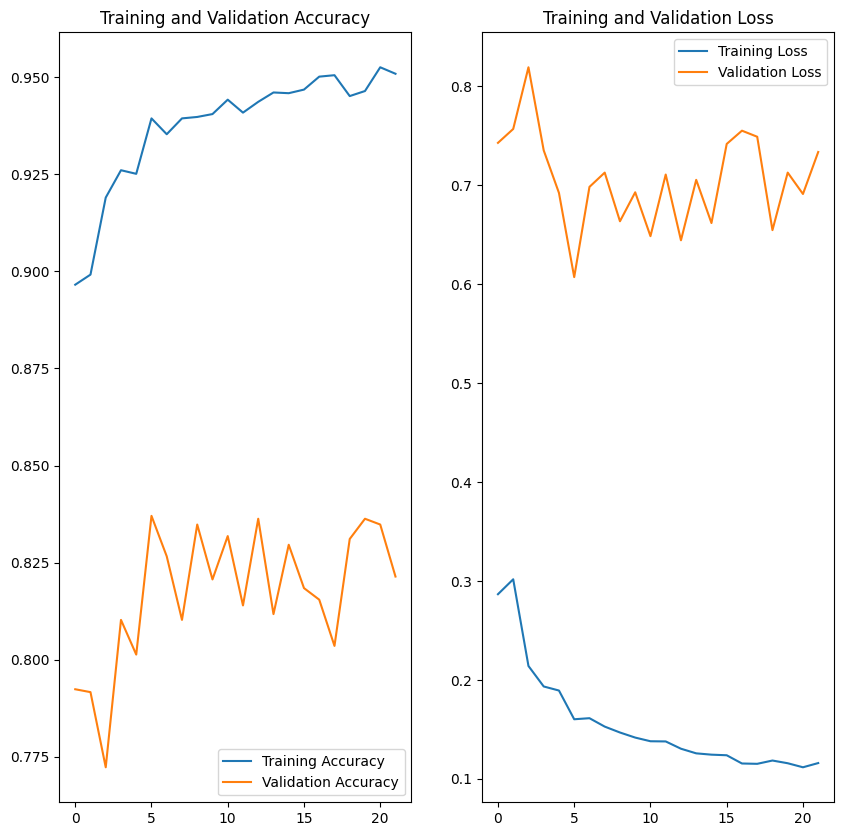

In [51]:
# Visualize the training results
epochs_range = range(epochs)

acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']

loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Initially there was class imbalance - which was resolved with augmentation of samples
# The underfitting problem was resolved
# The Final model is performing pretty well
#     :  Training Accuracy   = 95%
#     :  Validation Accuracy = 82%

In [45]:
# Predict using the model
predictions = model.predict(test_ds)
print(predictions)

4/4 [==============================] - 4s 23ms/step
[[0.000000e+00 1.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [0.000000e+00 1.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 0.000000e+00 ... 0.000000e+00 1.940334e-24
  0.000000e+00]
 [0.000000e+00 1.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]
